## Что нужно обосновать?



**Model Dependency**

Фиксируем Датасет 

Метрика: число разных кластеров (т.е. сколько у разных моделей разных кластеров)

**Randomization**

Просто средняя дисперсия по всей кривой? Отдельно -- пересечения (Жакар?) оптимумов, и дисперсия внутри оптимумов (по всем точкам, которые попали хотя бы в один оптимум) 

**Methods' disagreement**

Кажется, тут нужно для каждого датасета и модели посчитать интервалы числа тем и дать статистику о том, насколько их пересечение пустое?


> и между априорными предположениями о числе тем/категорий, когда они есть у датасета. 

Кажется, тут нужно показать пальцем на WRef220?



**Objectivity concerns**
???



**Synthetic corpus**
???

## Properties of studied metrics 

**Diversity**

Diversity vs max(AIC): во сколько раз больше

какую диверсити взять? давай пока все, потом обсудим

каждая клеточка -- это датасет и модель

**Information-theoretic**

Модель х Датасет

смог ли он сделать оценку? через запятую

**expected results**

WRef, 20NG: 
метрика, модель, значение $T$. Болдом отметить там, где оно ОК


**TODO:** починить Outside и попробовать плато

In [1]:
import glob
import itertools
import os
import time
import sys

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
sys.path.insert(0, '../OptimalNumberOfTopics/')     # topnum

sys.path.insert(1, '/home/bulatov/bb_topicnet/')  # topicnet

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from topicnet.cooking_machine.models import TopicModel
from topicnet.cooking_machine.dataset import Dataset

from topnum.data.vowpal_wabbit_text_collection import VowpalWabbitTextCollection
from topnum.search_methods.optimize_scores_method import OptimizeScoresMethod
from topnum.utils import (
    read_corpus_config, split_into_train_test, 
    build_every_score, monotonity_and_std_analysis, 
    trim_config, classify_curve, SCORES_DIRECTION, load_models_from_disk
)
from topnum.model_constructor import KnownModel, PARAMS_EXPLORED
from topnum.utils import estimate_num_iterations_for_convergence

from collections import defaultdict

In [6]:
!ls /data/_tmp_alekseev/OptNumExperiments/AllDatasets/

20NG_20NG_NEW	 PN_PN_NEW	      SO_SO_NEW
Brown_Brown_NEW  Reuters_Reuters_NEW  WRef_NEW


In [7]:


EXPERIMENTS_DICT = {
    "20NewsGroups": "/data/_tmp_alekseev/OptNumExperiments/AllDatasets/20NG_20NG_NEW",
    # "RuWikiGood": 
    "StackOverflow": "/data/_tmp_alekseev/OptNumExperiments/AllDatasets/SO_SO_NEW",
    "WikiRef220": "/data/_tmp_alekseev/OptNumExperiments/AllDatasets/WRef_NEW/",
    "PostNauka": "/data/_tmp_alekseev/OptNumExperiments/AllDatasets/PN_PN_NEW",
    # "Reuters": "/data/_tmp_alekseev/OptNumExperiments/AllDatasets/"
    "Brown": "/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Brown_Brown_NEW",
}


In [8]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [9]:
! cp /home/alekseev/OptimalNumberOfTopics/demos/*_test.csv  .

In [158]:
df.model_family.value_counts()

ARTM             5508
sparse           1836
LDA              1377
decorrelation    1377
TARTM             459
PLSA              459
Name: model_family, dtype: int64

In [9]:
# %%prun -s cumulative -q -l 600 -T prun0

EXPERIMENT_NAME_TEMPLATE = "_{mfv}_{param_id}_{seed}"

configs_dir = os.path.join('..', 'OptimalNumberOfTopics', 'topnum', 'configs')
configs_mask = os.path.join(configs_dir, '*.yml')

data_results = []
optimum_tolerance = 0.07

from time import time

start = time()
start2 = time()

for config_file in glob.glob(configs_mask):
    config = read_corpus_config(config_file)

    if config['name'] in EXPERIMENTS_DICT:
        print(config['name'])
        experiment_directory = EXPERIMENTS_DICT[config['name']]
        
        for model_family in KnownModel:
            #if model_family != KnownModel.ARTM:
            #    continue
            # print(model_family, end=", ")
            print(model_family, (time() - start)/60)
            start = time()
            tmp = "WRef_test" if config['name'] == "WikiRef220" else config['batches_prefix']
            template = tmp + EXPERIMENT_NAME_TEMPLATE.format(
                mfv=model_family.value, param_id="{}", seed="{}"
            )

            details = defaultdict(dict)

            all_subexperems_mask = os.path.join(
                experiment_directory, template.format("*", "*")
            )

            for entry in glob.glob(all_subexperems_mask):
                experiment_name = entry.split("/")[-1]

                result, detailed_result = load_models_from_disk(
                    experiment_directory, experiment_name
                )

                for score in detailed_result.keys():
                    if SCORES_DIRECTION[score] is not None:
                        details[score][experiment_name] = detailed_result[score].T
            for score in details.keys():
                for experiment_name, data in details[score].items():
                    
                    *name_base, param_id, seed = experiment_name.split("_")
                    seed = int(seed)
                    my_data = data.T.mean(axis=0)

                    score_direction = SCORES_DIRECTION[score]
                    colored_values, curve_type = classify_curve(my_data, optimum_tolerance, score_direction)
                    
                    data_results.append(
                        [
                            config['name'], model_family.value, param_id, seed, score, 
                            str(curve_type).split(".")[1], 
                            list(colored_values[colored_values.notna()].index),
                            data.values.T.tolist()[0], data.index.tolist(), 
                            config['max_num_topics'],
                            config['min_num_topics'],
                        ]
                    )
            print()

end = time()
print((end-start2)/60)


20NewsGroups
KnownModel.LDA 0.00011856953303019206


/data/topicnet/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)



KnownModel.PLSA 0.04267243941624959

KnownModel.SPARSE 0.014087859789530437

KnownModel.TLESS 0.05841354926427205

KnownModel.DECORRELATION 0.01438299020131429

KnownModel.ARTM 0.04195467233657837

StackOverflow
KnownModel.LDA 0.1695964217185974

KnownModel.PLSA 0.21972552935282388

KnownModel.SPARSE 0.07135722239812216

KnownModel.TLESS 0.28281375964482625

KnownModel.DECORRELATION 0.07730782429377238

KnownModel.ARTM 0.21555460294087728

WikiRef220
KnownModel.LDA 0.8268282135327657

KnownModel.PLSA 0.04619515736897786

KnownModel.SPARSE 0.015402328968048096

KnownModel.TLESS 0.06176377137502034

KnownModel.DECORRELATION 0.01563537915547689

KnownModel.ARTM 0.04761515061060587

PostNauka
KnownModel.LDA 0.18488688468933107

KnownModel.PLSA 0.046181893348693846

KnownModel.SPARSE 0.014711026350657146

KnownModel.TLESS 0.05838270982106527

KnownModel.DECORRELATION 0.014829734961191813

KnownModel.ARTM 0.046952009201049805

Brown
KnownModel.LDA 0.18261788686116537

KnownModel.PLSA 0.0390

In [10]:
test_dataset = Dataset('/home/alekseev/topicnet/tests/test_data/test_dataset.csv', internals_folder_path="./DELETE_ME_PLZ")


In [11]:
import pandas as pd

In [159]:
rwg_df = pd.read_pickle("rwg_df.pkl")

rwg_df

,corpus,model_family,parameters_id,seed,score,curve_type,optimums,numeric_values,T_index,max_num_topics,min_num_topics
0,RuWikiGood,LDA,0,0,SparsityThetaScore,EMPTY,"[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...",100,5
1,RuWikiGood,LDA,2,0,SparsityThetaScore,EMPTY,"[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...",100,5
2,RuWikiGood,LDA,2,2,SparsityThetaScore,EMPTY,"[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...",100,5
3,RuWikiGood,LDA,0,2,SparsityThetaScore,EMPTY,"[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...",100,5
4,RuWikiGood,LDA,2,1,SparsityThetaScore,EMPTY,"[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...",100,5
...,...,...,...,...,...,...,...,...,...,...,...
2083,RuWikiGood,ARTM,11,2,lift,JUMP_OUTSIDE,"[71, 91, 101]","[-1.4707727947468596, 4.373855301183862, 15.24...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5
2084,RuWikiGood,ARTM,6,0,lift,OUTSIDE,"[71, 81, 91, 101]","[-12.039903371843643, -7.042359885867159, 3.58...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5
2085,RuWikiGood,ARTM,10,1,lift,OUTSIDE,"[81, 91, 101]","[-0.7669003183301714, 1.0327192921045267, 11.0...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5
2086,RuWikiGood,ARTM,9,0,lift,OUTSIDE,"[81, 91, 101]","[-1.8358684832815395, -3.2561314024196806, 6.0...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5


In [12]:
m = EXPERIMENTS_DICT["20NewsGroups"]
! ls $m/20NG_ARTM_0_0/f136674d-3895-474a-883c-837440b86a86

AIC_sparsity_False._LikelihoodBasedScore.p
AIC_sparsity_True._LikelihoodBasedScore.p
arun._SpectralDivergenceScore.p
BIC_sparsity_False._LikelihoodBasedScore.p
BIC_sparsity_True._LikelihoodBasedScore.p
calhar._CalinskiHarabaszScore.p
diversity_cosine_False._DiversityScore.p
diversity_cosine_True._DiversityScore.p
diversity_euclidean_False._DiversityScore.p
diversity_euclidean_True._DiversityScore.p
diversity_hellinger_False._DiversityScore.p
diversity_hellinger_True._DiversityScore.p
diversity_jensenshannon_False._DiversityScore.p
diversity_jensenshannon_True._DiversityScore.p
intra._IntratextCoherenceScore.p
lift._MeanLiftScore.p
MDL_sparsity_False._LikelihoodBasedScore.p
MDL_sparsity_True._LikelihoodBasedScore.p
model
new_holdout_perp._HoldoutPerplexityScore.p
params.json
phi.csv
renyi_0.5._RenyiShannonEntropyScore.p
renyi_1._RenyiShannonEntropyScore.p
renyi_2._RenyiShannonEntropyScore.p
silh._SilhouetteScore.p
toptok1._TopTokensCoherenceScore.p
uni_theta_divergence._UniformThetaDive

In [13]:
from topicnet.cooking_machine.models import DummyTopicModel

path = m+'/20NG_ARTM_0_0/f136674d-3895-474a-883c-837440b86a86'
dm = DummyTopicModel.load(path)

In [14]:
df = pd.DataFrame(data=data_results, columns=["corpus", "model_family", "parameters_id", "seed", "score", "curve_type", "optimums", 'numeric_values', 'T_index', 'max_num_topics', 'min_num_topics'])

df

,corpus,model_family,parameters_id,seed,score,curve_type,optimums,numeric_values,T_index,max_num_topics,min_num_topics
0,20NewsGroups,LDA,1,2,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10
1,20NewsGroups,LDA,0,1,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10
2,20NewsGroups,LDA,2,2,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10
3,20NewsGroups,LDA,0,0,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10
4,20NewsGroups,LDA,1,1,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10
...,...,...,...,...,...,...,...,...,...,...,...
11011,Brown,ARTM,0,2,new_holdout_perp,OUTSIDE,"[27, 30]","[2403.397705078125, 2295.171875, 2249.53222656...","[6, 9, 12, 15, 18, 21, 24, 27, 30]",25,5
11012,Brown,ARTM,8,1,new_holdout_perp,OUTSIDE,"[27, 30]","[2883.9013671875, 2883.901123046875, 2428.6345...","[6, 9, 12, 15, 18, 21, 24, 27, 30]",25,5
11013,Brown,ARTM,7,0,new_holdout_perp,OUTSIDE,"[27, 30]","[2527.578125, 2419.661376953125, 2345.38452148...","[6, 9, 12, 15, 18, 21, 24, 27, 30]",25,5
11014,Brown,ARTM,11,2,new_holdout_perp,OUTSIDE,"[24, 27, 30]","[2883.90185546875, 2883.901611328125, 2883.901...","[6, 9, 12, 15, 18, 21, 24, 27, 30]",25,5


In [161]:
df = pd.concat([df, rwg_df])

In [18]:
# df.pivot_table(index=['score', 'curve_type'], aggfunc='count')
table = df.query("model_family != 'ARTM'").pivot_table(
    values="seed", 
    index=['score'], columns=['curve_type'], aggfunc='count', 
    fill_value=0
)



In [ ]:
df.query("curve_type == 'PEAK' and score == 'toptok1'")



**Что мы видим:** у топ-токенов острый максимум, но он не совпадает по разным перезапускам

## Устойчивсть по рандомизации

Просто средняя дисперсия по всей кривой? Отдельно -- пересечения (Жакар?) оптимумов, и дисперсия внутри оптимумов (по всем точкам, которые попали хотя бы в один оптимум)

In [165]:
from functools import reduce


In [20]:
df.columns

Index(['corpus', 'model_family', 'parameters_id', 'seed', 'score',
       'curve_type', 'optimums', 'numeric_values', 'T_index', 'max_num_topics',
       'min_num_topics'],
      dtype='object')

In [162]:
groupee = df.groupby(["corpus", "model_family", 'parameters_id', 'score'])



In [177]:
for g, gdf in groupee:
    break


In [178]:
gdf

,corpus,model_family,parameters_id,seed,score,curve_type,optimums,numeric_values,T_index,max_num_topics,min_num_topics,managed
1880,20NewsGroups,ARTM,0,0,AIC_sparsity_False,OUTSIDE,"[30, 33, 36, 39]","[15430293.253204603, 14605243.36492094, 143880...","[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]",30,10,False
1892,20NewsGroups,ARTM,0,2,AIC_sparsity_False,OUTSIDE,"[30, 33, 36, 39]","[15430293.227587353, 14600416.630483417, 14384...","[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]",30,10,False
1893,20NewsGroups,ARTM,0,1,AIC_sparsity_False,OUTSIDE,"[33, 36, 39]","[15430293.324925244, 14548707.930511521, 14370...","[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]",30,10,False


In [179]:
optima_union = list(reduce(lambda a, b: set(a) | set(b), gdf.optimums))
optima_intersect = list(reduce(lambda a, b: set(a) & set(b), gdf.optimums))


tmp = pd.DataFrame.from_records(gdf.numeric_values.values).T


tmp['T_index'] = gdf.T_index.iloc[0]

tmp.set_index("T_index", inplace=True)

scale = tmp.max().max() - tmp.min().min()
relative_delta = (tmp.max(axis=1) - tmp.min(axis=1)) / scale

if gdf.curve_type == "OUTSIDE":
    optima_intersect = []

if optima_union:
    jaccard = 1 - len(optima_intersect)/len(optima_union)
else:
    jaccard = float("nan") 


In [187]:
set(gdf.curve_type.unique()) == {'OUTSIDE'}

True

In [181]:
optima_union, optima_intersect

([33, 36, 39, 30], [33, 36, 39])

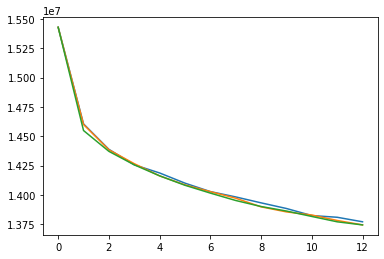

In [184]:
plt.plot(gdf.iloc[0].numeric_values)
plt.plot(gdf.iloc[1].numeric_values)
plt.plot(gdf.iloc[2].numeric_values)


In [166]:
def calc_stability(gdf):

    optima_union = list(reduce(lambda a, b: set(a) | set(b), gdf.optimums))
    optima_intersect = list(reduce(lambda a, b: set(a) & set(b), gdf.optimums))


    tmp = pd.DataFrame.from_records(gdf.numeric_values.values).T


    tmp['T_index'] = gdf.T_index.iloc[0]

    tmp.set_index("T_index", inplace=True)

    scale = tmp.max().max() - tmp.min().min()
    relative_delta = (tmp.max(axis=1) - tmp.min(axis=1)) / scale
    if optima_union:
        jaccard = 1 - len(optima_intersect)/len(optima_union)
    else:
        jaccard = float("nan") 

    return relative_delta.loc[optima_union].mean(), relative_delta.mean(), jaccard



In [245]:
#groupee = df.query("curve_type != 'OUTSIDE' and curve_type != 'EMPTY'").groupby(["corpus", "model_family", 'parameters_id', 'score'])



In [247]:
groupee = df.groupby(["corpus", "model_family", 'parameters_id', 'score'])


In [248]:
calculated_stab = pd.DataFrame(groupee.apply(calc_stability))


calculated_stab["avg_rel_delta_opt"] = calculated_stab[0].apply(lambda x: x[0])
calculated_stab["avg_rel_delta_all"] = calculated_stab[0].apply(lambda x: x[1])
calculated_stab["jaccard"] = calculated_stab[0].apply(lambda x: x[2])

calculated_stab.drop(columns=[0], inplace=True)




/data/topicnet/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in double_scalars


In [249]:
calculated_stab.groupby(['score', 'corpus']).agg('mean')['jaccard'].unstack()#.sort_values(by=['jaccard'])

corpus,20NewsGroups,Brown,PostNauka,RuWikiGood,StackOverflow,WikiRef220
score,,,,,,
AIC_sparsity_False,0.236111,0.309028,0.276359,0.234028,0.015278,0.611111
AIC_sparsity_True,0.378472,0.319444,0.198148,0.156746,0.023611,0.240278
BIC_sparsity_False,0.175099,0.125000,0.208333,0.041667,0.015278,0.204861
BIC_sparsity_True,0.395833,0.320833,0.259722,0.287897,0.023611,0.356180
MDL_sparsity_False,0.210813,0.062500,0.111111,0.041667,0.034722,0.118056
MDL_sparsity_True,0.196181,0.383333,0.182738,0.325347,0.016667,0.588095
SparsityPhiScore@lemmatized,NaN,NaN,NaN,0.050099,0.080724,0.309375
SparsityPhiScore@word,0.194097,0.270833,0.229167,NaN,NaN,NaN
SparsityThetaScore,0.392361,0.405093,0.444444,0.148878,0.221627,0.255556


In [200]:
df.query("score == 'TopicKernel@lemmatized.average_purity' and model_family == 'PLSA' and corpus == 'RuWikiGood'")

,corpus,model_family,parameters_id,seed,score,curve_type,optimums,numeric_values,T_index,max_num_topics,min_num_topics,managed
270,RuWikiGood,PLSA,0,2,TopicKernel@lemmatized.average_purity,PEAK,[2],"[0.9437206983566284, 0.640830397605896, 0.4214...","[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...",100,5,NaN
271,RuWikiGood,PLSA,0,1,TopicKernel@lemmatized.average_purity,PEAK,[2],"[0.9266183376312256, 0.6759700775146484, 0.438...","[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...",100,5,NaN
272,RuWikiGood,PLSA,0,0,TopicKernel@lemmatized.average_purity,PEAK,[2],"[0.9151639342308044, 0.6561241149902344, 0.431...","[2, 4, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, ...",100,5,NaN


In [234]:
row = df.query("curve_type == 'PEAK'").iloc[0]

row

corpus                                                 20NewsGroups
model_family                                                    LDA
parameters_id                                                     1
seed                                                              2
score                             TopicKernel@word.average_contrast
curve_type                                                     PEAK
optimums                                                        [2]
numeric_values    [0.7118598222732544, 0.6064776182174683, 0.580...
T_index           [2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]
max_num_topics                                                   30
min_num_topics                                                   10
managed                                                       False
Name: 18, dtype: object

In [237]:
int_len = df.optimums.apply(len)

df[int_len < 3].query("curve_type != 'OUTSIDE' and curve_type != 'PEAK'")


,corpus,model_family,parameters_id,seed,score,curve_type,optimums,numeric_values,T_index,max_num_topics,min_num_topics,managed
99,20NewsGroups,LDA,1,2,diversity_cosine_True,INTERVAL,"[20, 23]","[0.611115527947226, 0.5003353265755183, 0.5372...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,True
154,20NewsGroups,LDA,0,1,renyi_0.5,INTERVAL,"[5, 8]","[1.793528558201512, 1.369764850963021, 1.39020...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,False
161,20NewsGroups,LDA,0,2,renyi_0.5,INTERVAL,"[5, 8]","[2.207309787429051, 1.362934934886515, 1.40131...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,False
164,20NewsGroups,LDA,2,2,renyi_1,INTERVAL,"[5, 8]","[2.9872550192704104, 1.897249471433533, 1.8436...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,False
168,20NewsGroups,LDA,1,0,renyi_1,INTERVAL,"[14, 17]","[3.083836435631304, 3.4784739996067406, 2.7635...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2027,RuWikiGood,ARTM,6,1,uni_theta_divergence,JUMP_OUTSIDE,"[81, 101]","[0.28376902184305625, 0.2814410346031787, 0.17...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5,True
2042,RuWikiGood,ARTM,7,1,uni_theta_divergence,JUMP_OUTSIDE,"[81, 101]","[0.3961730606338031, 0.4086407693878249, 0.301...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5,True
2048,RuWikiGood,ARTM,6,0,uni_theta_divergence,JUMP_OUTSIDE,"[3, 101]","[0.34954422856971146, 0.1612501239137568, 0.23...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5,False
2049,RuWikiGood,ARTM,10,1,uni_theta_divergence,INTERVAL,"[3, 5]","[0.7330596926129296, 0.7142295348335457, 0.399...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5,False


In [244]:

def peak_hack(row):
    fixed_val = row.curve_type
    if len(row.optimums) < 3:
        if len(row.optimums) == 1:
            if row.optimums[0] in [row.T_index[0], row.T_index[-1]]:
                fixed_val = "OUTSIDE"
        if len(row.optimums) == 2:
            if set(row.optimums) == set(row.T_index[:2]):
                fixed_val = "OUTSIDE"
            if set(row.optimums) == set(row.T_index[-2:]):
                fixed_val = "OUTSIDE"
    return fixed_val


df.curve_type = df.apply(peak_hack, axis=1)

In [198]:
calculated_stab.groupby(['score', 'model_family']).agg('mean')['jaccard'].unstack()#.sort_values(by=['jaccard'])

model_family,ARTM,LDA,PLSA,TARTM,decorrelation,sparse
score,,,,,,
AIC_sparsity_False,0.381560,0.235043,0.062500,0.615714,0.202381,0.316319
AIC_sparsity_True,0.800000,0.235043,NaN,0.333333,0.050000,0.000000
BIC_sparsity_False,0.174528,0.100000,0.000000,0.200000,0.133333,0.151003
BIC_sparsity_True,0.284615,0.100000,0.504808,0.420000,0.335714,0.304029
MDL_sparsity_False,0.099603,0.105556,0.000000,0.200000,0.144444,0.116667
MDL_sparsity_True,0.478634,0.105556,0.187500,0.250000,0.250000,0.573214
SparsityPhiScore@lemmatized,0.535714,0.000000,NaN,NaN,0.000000,0.000000
SparsityPhiScore@word,0.500000,0.000000,NaN,NaN,0.050000,NaN
SparsityThetaScore,0.440972,0.000000,0.125000,0.200000,0.337464,0.166667


In [250]:
calculated_stab.groupby(['score', 'corpus']).agg('mean')['jaccard'].unstack().mean(axis=1).sort_values()

score
MDL_sparsity_False                         0.096478
BIC_sparsity_False                         0.128373
SparsityPhiScore@lemmatized                0.146733
holdout_perp                               0.217783
perp                                       0.217783
AIC_sparsity_True                          0.219450
new_holdout_perp                           0.228296
renyi_2                                    0.229811
SparsityPhiScore@word                      0.231366
silh                                       0.232755
TopicKernel@word.average_purity            0.256944
TopicKernel@word.average_contrast          0.270116
BIC_sparsity_True                          0.274013
calhar                                     0.276544
TopicKernel@lemmatized.average_contrast    0.278362
AIC_sparsity_False                         0.280319
MDL_sparsity_True                          0.282060
diversity_jensenshannon_False              0.302174
TopicKernel@lemmatized.average_purity      0.307407
Sparsi

In [251]:
RESULTS = pd.DataFrame()

In [252]:
RESULTS["avg_jaccard"] = calculated_stab.groupby(['score', 'corpus']).agg('mean')['jaccard'].unstack().mean(axis=1)

In [253]:
RESULTS

,avg_jaccard
score,
AIC_sparsity_False,0.280319
AIC_sparsity_True,0.219450
BIC_sparsity_False,0.128373
BIC_sparsity_True,0.274013
MDL_sparsity_False,0.096478
MDL_sparsity_True,0.282060
SparsityPhiScore@lemmatized,0.146733
SparsityPhiScore@word,0.231366
SparsityThetaScore,0.311326


In [174]:
calculated_stab.groupby(['score', 'corpus']).agg('mean')['jaccard'].unstack().max(axis=1)

score
AIC_sparsity_False                         0.611111
AIC_sparsity_True                          0.378472
BIC_sparsity_False                         0.208333
BIC_sparsity_True                          0.395833
MDL_sparsity_False                         0.210813
MDL_sparsity_True                          0.588095
SparsityPhiScore@lemmatized                0.309375
SparsityPhiScore@word                      0.270833
SparsityThetaScore                         0.444444
TopicKernel@lemmatized.average_contrast    0.404861
TopicKernel@lemmatized.average_purity      0.446528
TopicKernel@word.average_contrast          0.393308
TopicKernel@word.average_purity            0.322917
arun                                       0.574345
calhar                                     0.466601
diversity_cosine_False                     0.726389
diversity_cosine_True                      0.668578
diversity_euclidean_False                  0.924306
diversity_euclidean_True                   0.858978
divers

In [169]:
calculated_stab.groupby(['score']).agg('mean').sort_values(by=['avg_rel_delta_opt'])

,avg_rel_delta_opt,avg_rel_delta_all,jaccard
score,,,
MDL_sparsity_False,0.016706,0.014948,0.096478
SparsityPhiScore@lemmatized,0.024919,0.023689,0.146733
renyi_2,0.024940,0.037802,0.229811
BIC_sparsity_False,0.025903,0.018197,0.128373
holdout_perp,0.034231,0.038829,0.217783
perp,0.034231,0.038829,0.217783
renyi_1,0.039093,0.051596,0.356039
new_holdout_perp,0.043329,0.049772,0.228296
AIC_sparsity_True,0.046890,0.044413,0.219450


## Проверка на общую адекватность

In [254]:
adeq_table = df.groupby("score").apply(
    lambda gdf: gdf.curve_type.value_counts()
).unstack(fill_value=0)

for score in ["TopicKernel@{}.average_contrast", "TopicKernel@{}.average_purity", "SparsityPhiScore@{}"]:
    print(score)
    adeq_table.loc[score.format("ALL"), :] = adeq_table.loc[score.format("lemmatized"), :] + adeq_table.loc[score.format("word"), :]
    adeq_table.drop(score.format("word"), inplace=True)
    adeq_table.drop(score.format("lemmatized"), inplace=True)



TopicKernel@{}.average_contrast
TopicKernel@{}.average_purity
SparsityPhiScore@{}


In [255]:
adeq_table['IP'] = adeq_table['INTERVAL'] + adeq_table['PEAK']

In [256]:
adeq_table['IP'] / (adeq_table.sum(axis=1) - adeq_table['IP'])

score
AIC_sparsity_False                  0.541667
AIC_sparsity_True                   0.111111
BIC_sparsity_False                  0.444444
BIC_sparsity_True                   0.164352
MDL_sparsity_False                  0.488426
MDL_sparsity_True                   0.428241
SparsityThetaScore                  0.141204
arun                                0.143519
calhar                              0.157407
diversity_cosine_False              0.113426
diversity_cosine_True               0.148148
diversity_euclidean_False           0.250000
diversity_euclidean_True            0.243056
diversity_hellinger_False           0.062500
diversity_hellinger_True            0.245370
diversity_jensenshannon_False       0.053241
diversity_jensenshannon_True        0.194444
holdout_perp                        0.023148
intra                               0.343750
lift                                0.122685
new_holdout_perp                    0.025463
perp                                0.023148
reny

In [258]:
RESULTS["informativity"] = adeq_table['IP'] / (adeq_table.sum(axis=1) - adeq_table['IP'])

In [229]:
adeq_table.sort_values(by=["INTERVAL"], ascending=False)

,EMPTY,INTERVAL,JUMPING,JUMP_OUTSIDE,OUTSIDE,PEAK,IP
score,,,,,,,
MDL_sparsity_False,0.0,255.0,0.0,13.0,72.0,92.0,347.0
AIC_sparsity_False,0.0,230.0,10.0,4.0,157.0,31.0,261.0
BIC_sparsity_False,0.0,214.0,0.0,19.0,104.0,95.0,309.0
renyi_0.5,0.0,205.0,46.0,29.0,79.0,73.0,278.0
renyi_1,0.0,181.0,32.0,24.0,170.0,25.0,206.0
MDL_sparsity_True,0.0,176.0,14.0,2.0,179.0,61.0,237.0
renyi_2,0.0,126.0,8.0,27.0,268.0,3.0,129.0
BIC_sparsity_True,0.0,61.0,5.0,40.0,278.0,48.0,109.0
TopicKernel@ALL.average_contrast,0.0,60.0,3.0,24.0,73.0,272.0,332.0


In [227]:
df

,corpus,model_family,parameters_id,seed,score,curve_type,optimums,numeric_values,T_index,max_num_topics,min_num_topics,managed
0,20NewsGroups,LDA,1,2,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,False
1,20NewsGroups,LDA,0,1,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,False
2,20NewsGroups,LDA,2,2,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,False
3,20NewsGroups,LDA,0,0,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,False
4,20NewsGroups,LDA,1,1,SparsityThetaScore,EMPTY,"[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2083,RuWikiGood,ARTM,11,2,lift,JUMP_OUTSIDE,"[71, 91, 101]","[-1.4707727947468596, 4.373855301183862, 15.24...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5,True
2084,RuWikiGood,ARTM,6,0,lift,OUTSIDE,"[71, 81, 91, 101]","[-12.039903371843643, -7.042359885867159, 3.58...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5,False
2085,RuWikiGood,ARTM,10,1,lift,OUTSIDE,"[81, 91, 101]","[-0.7669003183301714, 1.0327192921045267, 11.0...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5,False
2086,RuWikiGood,ARTM,9,0,lift,OUTSIDE,"[81, 91, 101]","[-1.8358684832815395, -3.2561314024196806, 6.0...","[3, 5, 9, 11, 21, 31, 41, 51, 61, 71, 81, 91, ...",100,5,False


In [19]:
adeq_table.sum(axis=1)

score
AIC_sparsity_False                  550.0
AIC_sparsity_True                   408.0
BIC_sparsity_False                  599.0
BIC_sparsity_True                   446.0
MDL_sparsity_False                  637.0
MDL_sparsity_True                   537.0
SparsityThetaScore                  441.0
arun                                476.0
calhar                              637.0
diversity_cosine_False              421.0
diversity_cosine_True               473.0
diversity_euclidean_False           468.0
diversity_euclidean_True            476.0
diversity_hellinger_False           434.0
diversity_hellinger_True            505.0
diversity_jensenshannon_False       426.0
diversity_jensenshannon_True        479.0
holdout_perp                        374.0
intra                               561.0
lift                                413.0
new_holdout_perp                    379.0
perp                                374.0
renyi_0.5                           583.0
renyi_1                     

## Проверка на частную адекватность

In [202]:
df.corpus.unique()

array(['20NewsGroups', 'StackOverflow', 'WikiRef220', 'PostNauka',
       'Brown', 'RuWikiGood'], dtype=object)

In [259]:
EXPERIMENTS_EXPECTED_T = {
    '20NewsGroups': list(range(15,21)),
    'StackOverflow': [],
    'WikiRef220': [5],
    'PostNauka': list(range(15,31)),
    'Brown': list(range(10,21)),
    'RuWikiGood': list(range(7,14)) + list(range(80,100)),
    # 'RuWikiGood': list(range(80,100)),
    # 'Reuters': list(range(15, 50))
}


In [260]:
def calc_if_row_succeeded(row):
    corpus = row.corpus
    # print(corpus, set(EXPERIMENTS_EXPECTED_T[corpus]))
    result = bool(set(row.optimums) & set(EXPERIMENTS_EXPECTED_T[corpus]))
    result &= (row.curve_type != "EMPTY") & (row.curve_type != "OUTSIDE")
    return result

df['managed'] = df.apply(calc_if_row_succeeded, axis=1)

In [222]:
df.query("corpus == 'RuWikiGood' and managed == True").score.value_counts()

AIC_sparsity_False                         72
BIC_sparsity_False                         72
MDL_sparsity_False                         72
renyi_0.5                                  67
MDL_sparsity_True                          43
renyi_1                                    41
diversity_hellinger_True                   41
diversity_cosine_True                      26
BIC_sparsity_True                          25
diversity_jensenshannon_True               24
diversity_cosine_False                     23
diversity_hellinger_False                  14
arun                                       14
diversity_euclidean_False                  14
renyi_2                                    11
AIC_sparsity_True                          11
uni_theta_divergence                        9
diversity_jensenshannon_False               6
diversity_euclidean_True                    5
lift                                        4
perp                                        3
holdout_perp                      

In [216]:
df.query("corpus == 'RuWikiGood' and managed == True").score.value_counts()

diversity_cosine_False                     23
MDL_sparsity_True                          18
arun                                       14
diversity_cosine_True                      14
diversity_hellinger_False                  14
renyi_2                                     9
uni_theta_divergence                        9
diversity_jensenshannon_False               6
diversity_hellinger_True                    5
diversity_euclidean_False                   4
lift                                        4
diversity_euclidean_True                    3
SparsityThetaScore                          2
renyi_1                                     2
perp                                        1
holdout_perp                                1
TopicKernel@lemmatized.average_contrast     1
BIC_sparsity_True                           1
new_holdout_perp                            1
renyi_0.5                                   1
SparsityPhiScore@lemmatized                 1
AIC_sparsity_True                 

In [38]:
df.query("corpus == 'Reuters'")

,corpus,model_family,parameters_id,seed,score,curve_type,optimums,numeric_values,T_index,max_num_topics,min_num_topics


In [261]:
groupee = df.groupby(["score", "corpus"])

res = groupee.apply(lambda gdf: gdf.managed.sum())
total = groupee.apply(lambda gdf: gdf.managed.count())

pivot_res = pd.DataFrame(res / total).unstack()

In [207]:
groupee = df.groupby(["score", "model_family"])

res = groupee.apply(lambda gdf: gdf.managed.sum())
total = groupee.apply(lambda gdf: gdf.managed.count())



In [262]:
pivot_res

0                      \
corpus                                  20NewsGroups     Brown PostNauka   
score                                                                      
AIC_sparsity_False                          0.000000  0.958333  0.416667   
AIC_sparsity_True                           0.013889  0.166667  0.041667   
BIC_sparsity_False                          0.194444  0.055556  0.541667   
BIC_sparsity_True                           0.069444  0.000000  0.138889   
MDL_sparsity_False                          0.652778  0.000000  0.138889   
MDL_sparsity_True                           0.083333  0.541667  0.000000   
SparsityPhiScore@lemmatized                      NaN       NaN       NaN   
SparsityPhiScore@word                       0.000000  0.069444  0.097222   
SparsityThetaScore                          0.027778  0.055556  0.111111   
TopicKernel@lemmatized.average_contrast          NaN       NaN       NaN   
TopicKernel@lemmatized.average_purity            NaN       NaN       NaN   
TopicKernel@word.average_contrast           0.125000  0.208333  0.166667   
TopicKernel@word.average_purity             0.125000  0.166667  0.166667   
arun                                        0.027778  0.000000  0.097222   
calhar                                      0.000000  0.000000  0.041667   
diversity_cosine_False                      0.013889  0.069444  0.013889   
diversity_cosine_True                       0.013889  0.208333  0.013889   
diversity_euclidean_False                   0.152778  0.194444  0.000000   
diversity_euclidean_True                    0.125000  0.180556  0.027778   
diversity_hellinger_False                   0.055556  0.097222  0.000000   
diversity_hellinger_True                    0.083333  0.027778  0.041667   
diversity_jensenshannon_False               0.000000  0.027778  0.000000   
diversity_jensenshannon_True                0.000000  0.013889  0.027778   
holdout_perp                                0.027778  0.000000  0.000000   
intra                                       0.055556  0.180556  0.166667   
lift                                        0.013889  0.069444  0.027778   
new_holdout_perp                            0.055556  0.000000  0.000000   
perp                                        0.027778  0.000000  0.000000   
renyi_0.5                                   0.152778  0.305556  0.555556   
renyi_1                                     0.625000  0.083333  0.694444   
renyi_2                                     0.388889  0.041667  0.333333   
silh                                        0.000000  0.013889  0.013889   
toptok1                                     0.152778  0.194444  0.250000   
uni_theta_divergence                        0.013889  0.055556  0.027778   

                                                                             
corpus                                  RuWikiGood StackOverflow WikiRef220  
score                                                                        
AIC_sparsity_False                        1.000000           0.0   0.513889  
AIC_sparsity_True                         0.152778           0.0   0.125000  
BIC_sparsity_False                        1.000000           0.0   0.513889  
BIC_sparsity_True                         0.347222           0.0   0.083333  
MDL_sparsity_False                        1.000000           0.0   0.277778  
MDL_sparsity_True                         0.597222           0.0   0.055556  
SparsityPhiScore@lemmatized               0.013889           0.0   0.000000  
SparsityPhiScore@word                          NaN           NaN        NaN  
SparsityThetaScore                        0.027778           0.0   0.000000  
TopicKernel@lemmatized.average_contrast   0.013889           0.0   0.125000  
TopicKernel@lemmatized.average_purity     0.000000           0.0   0.097222  
TopicKernel@word.average_contrast              NaN           NaN        NaN  
TopicKernel@word.average_purity                NaN           NaN    

In [208]:
res['toptok1']

model_family
ARTM             40
LDA               5
PLSA              2
TARTM             0
decorrelation     6
sparse            7
dtype: int64

In [209]:
total

score                 model_family 
AIC_sparsity_False    ARTM             216
                      LDA               54
                      PLSA              18
                      TARTM             18
                      decorrelation     54
                                      ... 
uni_theta_divergence  LDA               54
                      PLSA              18
                      TARTM             18
                      decorrelation     54
                      sparse            72
Length: 204, dtype: int64

In [210]:
pivot_res = pd.DataFrame(res / total).unstack()

In [264]:
pivot_res

0                      \
corpus                                  20NewsGroups     Brown PostNauka   
score                                                                      
AIC_sparsity_False                          0.000000  0.958333  0.416667   
AIC_sparsity_True                           0.013889  0.166667  0.041667   
BIC_sparsity_False                          0.194444  0.055556  0.541667   
BIC_sparsity_True                           0.069444  0.000000  0.138889   
MDL_sparsity_False                          0.652778  0.000000  0.138889   
MDL_sparsity_True                           0.083333  0.541667  0.000000   
SparsityPhiScore@lemmatized                      NaN       NaN       NaN   
SparsityPhiScore@word                       0.000000  0.069444  0.097222   
SparsityThetaScore                          0.027778  0.055556  0.111111   
TopicKernel@lemmatized.average_contrast          NaN       NaN       NaN   
TopicKernel@lemmatized.average_purity            NaN       NaN       NaN   
TopicKernel@word.average_contrast           0.125000  0.208333  0.166667   
TopicKernel@word.average_purity             0.125000  0.166667  0.166667   
arun                                        0.027778  0.000000  0.097222   
calhar                                      0.000000  0.000000  0.041667   
diversity_cosine_False                      0.013889  0.069444  0.013889   
diversity_cosine_True                       0.013889  0.208333  0.013889   
diversity_euclidean_False                   0.152778  0.194444  0.000000   
diversity_euclidean_True                    0.125000  0.180556  0.027778   
diversity_hellinger_False                   0.055556  0.097222  0.000000   
diversity_hellinger_True                    0.083333  0.027778  0.041667   
diversity_jensenshannon_False               0.000000  0.027778  0.000000   
diversity_jensenshannon_True                0.000000  0.013889  0.027778   
holdout_perp                                0.027778  0.000000  0.000000   
intra                                       0.055556  0.180556  0.166667   
lift                                        0.013889  0.069444  0.027778   
new_holdout_perp                            0.055556  0.000000  0.000000   
perp                                        0.027778  0.000000  0.000000   
renyi_0.5                                   0.152778  0.305556  0.555556   
renyi_1                                     0.625000  0.083333  0.694444   
renyi_2                                     0.388889  0.041667  0.333333   
silh                                        0.000000  0.013889  0.013889   
toptok1                                     0.152778  0.194444  0.250000   
uni_theta_divergence                        0.013889  0.055556  0.027778   

                                                                             
corpus                                  RuWikiGood StackOverflow WikiRef220  
score                                                                        
AIC_sparsity_False                        1.000000           0.0   0.513889  
AIC_sparsity_True                         0.152778           0.0   0.125000  
BIC_sparsity_False                        1.000000           0.0   0.513889  
BIC_sparsity_True                         0.347222           0.0   0.083333  
MDL_sparsity_False                        1.000000           0.0   0.277778  
MDL_sparsity_True                         0.597222           0.0   0.055556  
SparsityPhiScore@lemmatized               0.013889           0.0   0.000000  
SparsityPhiScore@word                          NaN           NaN        NaN  
SparsityThetaScore                        0.027778           0.0   0.000000  
TopicKernel@lemmatized.average_contrast   0.013889           0.0   0.125000  
TopicKernel@lemmatized.average_purity     0.000000           0.0   0.097222  
TopicKernel@word.average_contrast              NaN           NaN        NaN  
TopicKernel@word.average_purity                NaN           NaN    

In [269]:
RESULTS["expected"] = pivot_res.drop(columns=[(0, "StackOverflow")]).mean(axis=1)


In [267]:
pivot_res.sort_values(by=[(0,'PLSA')], ascending=False)
pivot_res.sort_values(by=['avg'], ascending=False)

KeyError: (0, 'PLSA')

In [223]:
(pd.DataFrame(res).unstack().sum(axis=1) / pd.DataFrame(total).unstack().sum(axis=1)).sort_values(ascending=False)

score
AIC_sparsity_False                         0.481481
BIC_sparsity_False                         0.384259
renyi_0.5                                  0.354167
MDL_sparsity_False                         0.344907
renyi_1                                    0.328704
MDL_sparsity_True                          0.212963
toptok1                                    0.208333
TopicKernel@word.average_contrast          0.166667
diversity_hellinger_True                   0.157407
renyi_2                                    0.152778
TopicKernel@word.average_purity            0.152778
diversity_cosine_True                      0.143519
intra                                      0.118056
BIC_sparsity_True                          0.106481
diversity_euclidean_False                  0.099537
AIC_sparsity_True                          0.083333
diversity_euclidean_True                   0.076389
diversity_hellinger_False                  0.074074
diversity_cosine_False                     0.074074
arun  

In [107]:
df.query("managed == True and score == 'toptok1' and model_family != 'ARTM'")

,corpus,model_family,parameters_id,seed,score,curve_type,optimums,numeric_values,T_index,max_num_topics,min_num_topics,managed
697,20NewsGroups,sparse,2,0,toptok1,JUMPING,"[9, 15]","[1.3479616704909092, 1.2873354601112474, 1.352...","[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39]",30,10,True
1080,20NewsGroups,decorrelation,2,2,toptok1,PEAK,[17],"[0.6251824956548084, 0.6251824956548084, 0.625...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,True
1085,20NewsGroups,decorrelation,1,2,toptok1,PEAK,[17],"[0.6251824956548084, 1.3222306435707092, 1.372...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,True
1088,20NewsGroups,decorrelation,2,1,toptok1,PEAK,[17],"[0.6251824956548084, 0.6251824956548084, 0.625...","[2, 5, 8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38]",30,10,True
4563,WikiRef220,LDA,2,0,toptok1,PEAK,[5],"[1.5485347459619556, 1.7958904636383768, 1.773...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",20,2,True
4565,WikiRef220,LDA,2,2,toptok1,PEAK,[5],"[1.754991055054276, 1.5740339492048268, 1.9463...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",20,2,True
4566,WikiRef220,LDA,1,0,toptok1,PEAK,[5],"[1.649709780215561, 1.7958904636383768, 1.9317...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",20,2,True
4570,WikiRef220,LDA,2,1,toptok1,PEAK,[5],"[1.8387568382716042, 1.4594801007343952, 2.236...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",20,2,True
4571,WikiRef220,LDA,0,1,toptok1,INTERVAL,"[4, 5]","[1.8387568382716042, 1.6979049521053802, 2.136...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",20,2,True
4680,WikiRef220,PLSA,0,1,toptok1,JUMPING,"[4, 5, 9]","[1.8387568382716042, 2.0243894425328754, 2.170...","[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",20,2,True


In [270]:
RESULTS

,avg_jaccard,informativity,expected
score,,,
AIC_sparsity_False,0.280319,0.541667,0.577778
AIC_sparsity_True,0.219450,0.111111,0.100000
BIC_sparsity_False,0.128373,0.444444,0.461111
BIC_sparsity_True,0.274013,0.164352,0.127778
MDL_sparsity_False,0.096478,0.488426,0.413889
MDL_sparsity_True,0.282060,0.428241,0.255556
SparsityPhiScore@lemmatized,0.146733,NaN,0.006944
SparsityPhiScore@word,0.231366,NaN,0.055556
SparsityThetaScore,0.311326,0.141204,0.044444


In [271]:
RESULTS.to_csv()

'score,avg_jaccard,informativity,expected\nAIC_sparsity_False,0.28031906365239695,0.5416666666666666,0.5777777777777778\nAIC_sparsity_True,0.21944995590828928,0.1111111111111111,0.09999999999999999\nBIC_sparsity_False,0.1283730158730159,0.4444444444444444,0.4611111111111111\nBIC_sparsity_True,0.27401275422108756,0.16435185185185186,0.1277777777777778\nMDL_sparsity_False,0.09647817460317461,0.48842592592592593,0.4138888888888889\nMDL_sparsity_True,0.28206018518518516,0.42824074074074076,0.2555555555555556\nSparsityPhiScore@lemmatized,0.1467327040243707,,0.006944444444444444\nSparsityPhiScore@word,0.23136574074074076,,0.05555555555555556\nSparsityThetaScore,0.3113264821598155,0.1412037037037037,0.044444444444444446\nTopicKernel@lemmatized.average_contrast,0.27836199294532626,,0.06944444444444445\nTopicKernel@lemmatized.average_purity,0.3074074074074074,,0.04861111111111111\nTopicKernel@word.average_contrast,0.2701162263662264,,0.16666666666666666\nTopicKernel@word.average_purity,0.256944

In [297]:
FILTERED_RESULTS = RESULTS.copy()

In [275]:
FILTERED_RESULTS.index

Index(['AIC_sparsity_False', 'AIC_sparsity_True', 'BIC_sparsity_False',
       'BIC_sparsity_True', 'MDL_sparsity_False', 'MDL_sparsity_True',
       'SparsityPhiScore@lemmatized', 'SparsityPhiScore@word',
       'SparsityThetaScore', 'TopicKernel@lemmatized.average_contrast',
       'TopicKernel@lemmatized.average_purity',
       'TopicKernel@word.average_contrast', 'TopicKernel@word.average_purity',
       'arun', 'calhar', 'diversity_cosine_False', 'diversity_cosine_True',
       'diversity_euclidean_False', 'diversity_euclidean_True',
       'diversity_hellinger_False', 'diversity_hellinger_True',
       'diversity_jensenshannon_False', 'diversity_jensenshannon_True',
       'holdout_perp', 'intra', 'lift', 'new_holdout_perp', 'perp',
       'renyi_0.5', 'renyi_1', 'renyi_2', 'silh', 'toptok1',
       'uni_theta_divergence'],
      dtype='object', name='score')

In [298]:
to_remain = ['AIC_sparsity_False', 'AIC_sparsity_True', 'BIC_sparsity_False',
       'BIC_sparsity_True', 'MDL_sparsity_False', 'MDL_sparsity_True',
       'arun', 'calhar', 'diversity_cosine_False', 'diversity_cosine_True',
       'diversity_euclidean_False', 'diversity_euclidean_True',
       'diversity_hellinger_False', 'diversity_hellinger_True',
       'diversity_jensenshannon_False', 'diversity_jensenshannon_True',
       'lift', 'new_holdout_perp', 'perp',
       'renyi_0.5', 'renyi_1', 'renyi_2', 'silh', 'toptok1',
       'uni_theta_divergence']
FILTERED_RESULTS = FILTERED_RESULTS.loc[to_remain]

In [296]:
['AIC_sparsity_False', 'AIC_sparsity_True', 'BIC_sparsity_False',
       'BIC_sparsity_True', 'MDL_sparsity_False', 'MDL_sparsity_True',
       'arun', 'calhar', 'diversity_cosine_False', 'diversity_cosine_True',
       'diversity_euclidean_False', 'diversity_euclidean_True',
       'diversity_hellinger_False', 'diversity_hellinger_True',
       'diversity_jensenshannon_False', 'diversity_jensenshannon_True',
       'lift', 'new_holdout_perp', 'perp',
       'renyi_0.5', 'renyi_1', 'renyi_2', 'silh', 'toptok1',
       'uni_theta_divergence']

renamer = {}
for elem in to_remain:
    renamed_elem = None
    if "_sparsity_" in elem:
        parts = elem.split("_")
        if parts[-1] == "False":
            renamed_elem = parts[0]
        else:
            renamed_elem = "sparse " + parts[0]

    if "diversity_" in elem:
        parts = elem.split("_")
        t = {"cosine": "COS", "euclidean": "L2", "hellinger": "H", "jensenshannon": "JH"}
        if parts[-1] == "False":
            renamed_elem = f"D-" + "avg-" + t[parts[1]]
        else:
            renamed_elem = f"D-" + "cls-" + t[parts[1]]
    if elem == 'new_holdout_perp':
        renamed_elem = "holdout_perplexity"
    if elem == 'perp':
        renamed_elem = "perplexity"
    if "renyi" in elem or "lift" in elem or "uni_theta_divergence" in elem:
        renamed_elem = elem
    if elem == 'arun':
        renamed_elem = "D-Spectral"
    if elem == 'calhar':
        renamed_elem = "CHI"
    if elem == 'silh':
        renamed_elem = "SilhC"
    if elem == 'toptok1':
        renamed_elem = "average coherence"
         

    renamer[elem] = renamed_elem.replace("_", "-")
    



In [299]:

FILTERED_RESULTS.rename(index=renamer)


,avg_jaccard,informativity,expected
score,,,
AIC,0.280319,0.541667,0.577778
sparse AIC,0.219450,0.111111,0.100000
BIC,0.128373,0.444444,0.461111
sparse BIC,0.274013,0.164352,0.127778
MDL,0.096478,0.488426,0.413889
sparse MDL,0.282060,0.428241,0.255556
D-Spectral,0.455632,0.143519,0.083333
CHI,0.276544,0.157407,0.008333
D-avg-COS,0.429921,0.113426,0.088889


In [300]:
FILTERED_RESULTS.rename(index=renamer, inplace=True)


In [301]:
print(FILTERED_RESULTS.to_latex(float_format="%.3f"))

\begin{tabular}{lrrr}
\toprule
{} &  avg\_jaccard &  informativity &  expected \\
score                &              &                &           \\
\midrule
AIC                  &        0.280 &          0.542 &     0.578 \\
sparse AIC           &        0.219 &          0.111 &     0.100 \\
BIC                  &        0.128 &          0.444 &     0.461 \\
sparse BIC           &        0.274 &          0.164 &     0.128 \\
MDL                  &        0.096 &          0.488 &     0.414 \\
sparse MDL           &        0.282 &          0.428 &     0.256 \\
D-Spectral           &        0.456 &          0.144 &     0.083 \\
CHI                  &        0.277 &          0.157 &     0.008 \\
D-avg-COS            &        0.430 &          0.113 &     0.089 \\
D-cls-COS            &        0.526 &          0.148 &     0.172 \\
D-avg-L2             &        0.682 &          0.250 &     0.119 \\
D-cls-L2             &        0.584 &          0.243 &     0.092 \\
D-avg-H              &   

In [313]:
FILTERED_RESULTS.sort_values(by="avg_jaccard").head(7)

,avg_jaccard,informativity,expected
score,,,
MDL,0.096478,0.488426,0.413889
BIC,0.128373,0.444444,0.461111
perplexity,0.217783,0.023148,0.013889
sparse AIC,0.219450,0.111111,0.100000
holdout-perplexity,0.228296,0.025463,0.019444
renyi-2,0.229811,0.298611,0.183333
SilhC,0.232755,0.078704,0.027778


In [310]:
FILTERED_RESULTS.sort_values(by="informativity").tail(7)

,avg_jaccard,informativity,expected
score,,,
sparse MDL,0.282060,0.428241,0.255556
BIC,0.128373,0.444444,0.461111
average coherence,0.779514,0.472222,0.208333
renyi-1,0.356039,0.474537,0.394444
MDL,0.096478,0.488426,0.413889
renyi-0.5,0.469522,0.506944,0.425000
AIC,0.280319,0.541667,0.577778


In [315]:
FILTERED_RESULTS.sort_values(by="expected").tail(11)

,avg_jaccard,informativity,expected
score,,,
sparse BIC,0.274013,0.164352,0.127778
D-cls-COS,0.526467,0.148148,0.172222
renyi-2,0.229811,0.298611,0.183333
D-cls-H,0.594895,0.245370,0.188889
average coherence,0.779514,0.472222,0.208333
sparse MDL,0.282060,0.428241,0.255556
renyi-1,0.356039,0.474537,0.394444
MDL,0.096478,0.488426,0.413889
renyi-0.5,0.469522,0.506944,0.425000


In [304]:
FILTERED_RESULTS.shape

(25, 3)

## разбирательство с Рейтерс (WIP)

In [110]:
!ls -lh /data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW


total 288K
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 08:45 Reuters_ARTM_0_0
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 06:47 Reuters_ARTM_0_1
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 11:19 Reuters_ARTM_0_2
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 03:51 Reuters_ARTM_1_0
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 04:17 Reuters_ARTM_10_0
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 08:02 Reuters_ARTM_10_1
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 09:45 Reuters_ARTM_10_2
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 04:46 Reuters_ARTM_1_1
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 12:06 Reuters_ARTM_11_0
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 09:48 Reuters_ARTM_11_1
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 08:08 Reuters_ARTM_11_2
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 10:19 Reuters_ARTM_1_2
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 06:50 Reuters_ARTM_2_0
drwxr-sr-x 32 alekseev shared_files 4,0K июл 23 11:11 Reuter

In [152]:
from collections import Counter

EXPERIMENT_NAME_TEMPLATE = "_{mfv}_{param_id}_{seed}"

configs_dir = os.path.join('..', 'OptimalNumberOfTopics', 'topnum', 'configs')
configs_mask = os.path.join(configs_dir, '*.yml')

for config_file in glob.glob(configs_mask):
    config = read_corpus_config(config_file)
    if config['name'] == "Reuters":
        break

    
for model_family in KnownModel:
    tmp = "WRef_test" if config['name'] == "WikiRef220" else config['batches_prefix']
    template = tmp + EXPERIMENT_NAME_TEMPLATE.format(
                mfv=model_family.value, param_id="{}", seed="{}"
    )
    experiment_directory = '/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW'

    details = defaultdict(dict)

    all_subexperems_mask = os.path.join(
        experiment_directory, template.format("*", "*")
    )
    print(all_subexperems_mask)

    for entry in glob.glob(all_subexperems_mask):
        print(entry)
        experiment_name = entry.split("/")[-1]
        print(experiment_name)

        masks = [
            f"{experiment_directory}/{experiment_name}_*",
            f"{experiment_directory}/{experiment_name}/*"
        ]
        for new_exp_format, mask in enumerate(masks):
            if not len(glob.glob(mask)):
                continue
            print(experiment_name, len(glob.glob(mask)))
            cnt = Counter()
            print(
                Counter(
                    os.stat(folder).st_mode
                    for folder in glob.glob(mask)
                )
            )
            for folder2 in glob.glob(mask):
                # if os.stat(folder2).st_mode == 17901:
                if os.stat(folder2).st_mode == 16893:
                    dm = DummyTopicModel.load(folder2)
                    break
            break
        break


        #result, detailed_result = load_models_from_disk(
        #    experiment_directory, experiment_name
        #)


/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_LDA_*_*
/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_LDA_1_0
Reuters_LDA_1_0
Reuters_LDA_1_0 49
Counter({16893: 49})
/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_PLSA_*_*
/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_PLSA_0_1
Reuters_PLSA_0_1
Reuters_PLSA_0_1 49
Counter({16893: 49})
/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_sparse_*_*
/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_sparse_1_1
Reuters_sparse_1_1
Reuters_sparse_1_1 49
Counter({16893: 49})
/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_TARTM_*_*
/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_TARTM_0_1
Reuters_TARTM_0_1
Reuters_TARTM_0_1 49
Counter({16893: 49})
/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuter

In [134]:
folder, os.stat(folder).st_mode

('/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_ARTM_7_1/c915337b-fccf-4a55-8714-8183c77536f9',
 17901)

In [137]:
test_dataset = Dataset(
    '/home/alekseev/topicnet/tests/test_data/test_dataset.csv',
    internals_folder_path="./DELETE_ME_PLZ"
)

_ = build_every_score(test_dataset, test_dataset, config)

In [148]:
from topnum.scores import (
        IntratextCoherenceScore, SophisticatedTopTokensCoherenceScore
)

IntratextCoherenceScore("jbi", test_dataset)
SophisticatedTopTokensCoherenceScore("sds", test_dataset)

In [149]:
tm = TopicModel.load(folder)

In [150]:
tm._model.num_phi_updates

40

In [155]:
tm2 = TopicModel.load(folder2)

In [156]:
tm2._model.num_phi_updates

40

In [140]:
! cp /home/alekseev/OptimalNumberOfTopics/demos/*_train.csv  .

In [125]:
for folder in glob.glob(mask):
    print(os.path.basename(folder), os.stat(folder).st_mode)


1b10b9e0-7580-4a5e-84c3-ed6977558c66 17901
a62450f1-f73b-4ad0-8ba8-908f81fdb842 17901
53d9b03d-1b48-43c5-8ee6-5b87727f06d7 17901
c707771e-4ca6-4cad-b1ca-2610c7a6cdd4 17901
3e777e7b-e380-4a8a-9770-00c7f51d8e8b 17901
706a8295-f197-40cc-9fd3-f433e023ed7c 17901
3eb8ef23-96bb-4976-9c98-2a4dde5e01bf 17901
2acd47f0-a8d3-48f3-84c2-dd37c051fa5a 17901
fc401ba7-9998-4551-bc7f-75f5b914b744 17901
519e97e1-bd96-4ed3-8d98-2ed81ec78fcf 17901
7b31662e-5ab2-4e61-9600-f3da64ff5cc5 17901
37fda116-68fe-48fe-b361-3f20c690c2e1 17901
81ccbb00-ddd9-4d97-b382-092136510e54 17901
f19f17c6-1950-43fa-a13c-3cf9df718968 17901
4ce47eb9-ee14-478f-8f8f-49c2619c9ead 17901
28951a46-d1cf-465c-a3f8-4b43c64fba9f 17901
d22f0f66-f7e8-4a31-9759-e26bbfc449cd 17901
3b9364e9-9d5e-4d4d-aa95-c12ef38dbd75 17901
079192a6-1353-4342-a12e-d163a603b259 17901
45962857-376e-44ff-893a-e1c8a0f7090b 17901
48a6dda0-358a-4e7f-ac91-8ecd330a5401 17901
95e51120-79c0-41c0-be4c-594d649d685a 17901
0c9950ac-8802-4946-b2c2-78a24aec64da 17901
581bd528-59

In [115]:
experiment_directory

'/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Brown_Brown_NEW'

In [112]:
config

OrderedDict([('name', 'Reuters'),
             ('batches_prefix', 'Reuters'),
             ('dataset_path', '/data_mil/datasets/Reuters/Reuters.csv'),
             ('word', '@word'),
             ('min_num_topics', 5),
             ('max_num_topics', 150),
             ('num_topics_interval', 5),
             ('num_fit_iterations', 40),
             ('num_restarts', 3)])

In [118]:
experiment_directory, experiment_name

('/data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW',
 'Reuters_ARTM_7_0')

In [120]:
base_experiment_name = experiment_name

Trying to load models from /data/_tmp_alekseev/OptNumExperiments/AllDatasets/Reuters_Reuters_NEW/Reuters_ARTM_7_0/*. 30 models found.
